## La detection de la depression sur les  réseaux sociaux


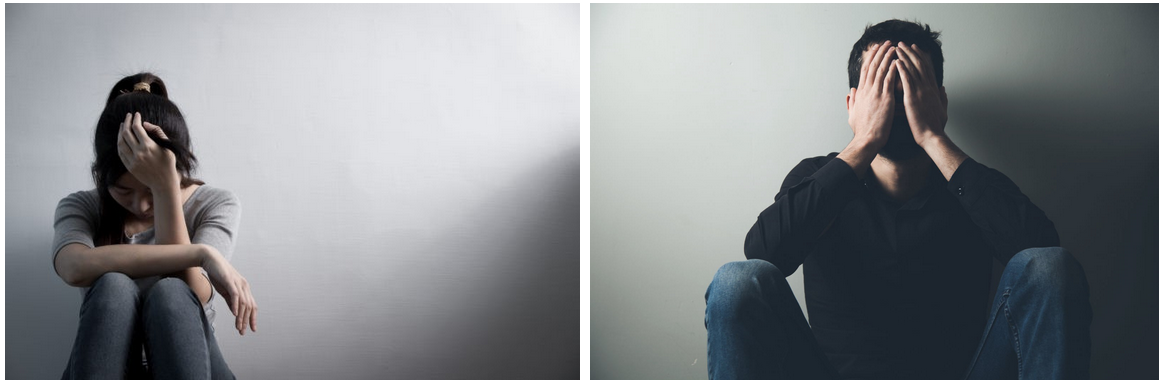

Étapes
1. Importation des bibliothèques
2. Création d'un objet SparkContext
3. Préparation des données
une. Comprendre les données et supprimer les colonnes indésirables
b. Filtrage des avis neutres
c. Attribution de sentiments positifs et négatifs aux avis en fonction du score
ré. Attribution de la notation binaire en tant que variable cible 1 : Positif 0 : Négatif
4. Pré-traitement de texte
une. Créer des fonctions UDF pour le traitement de texte : convertir en minuscules, supprimer les ponctuations et les mots alphanumériques, supprimer les mots vides
b. Étiquetage de point de vente
c. Lemmatisation du texte
5. Préparation des données pour la modélisation
une. Création de l'ensemble de données final avec des colonnes apt
b. Le diviser en ensemble d'entraînement et de test
c. Tokeniser l'ensemble de formation et créer une matrice TF-IDF à l'aide de HashingTF
6. Modélisation des données et évaluation du modèle
une. Modèle de régression logistique
b. Modèle naïf de Bayes
Importation de findSPark pour exécuter Pyspark dans le bloc-notes Jupyter

## 1.Importer les packages

In [ ]:
import pandas as pd


In [ ]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 39.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=b59227202cf6f6b374af9c4a297340839c9f14ccd900bd362c6fa1c14a159b59
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


##

In [ ]:
import pyspark

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import HiveContext
from pyspark.sql.functions import *
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

In [ ]:
#pip install vaderSentiment
#Importing Library and setting environment path
import os
import sys
#set the path 

%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize 

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 5.3 MB/s 


In [ ]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

from pyspark import HiveContext

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel,LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from vaderSentiment import vaderSentiment
from pyspark.ml.feature import NGram
import matplotlib
matplotlib.style.use('ggplot')

#2. Création d'un objet SparkContext

le spark_context représente votre interface avec un gestionnaire de cluster en
cours spark. En d'autres termes, vous aurez déjà défini un ou plusieurs
environnements en cours d'exécution pour spark , détaillant les nœuds sur lesquels
exécuter, etc. Vous démarrez un objet spark_context avec une configuration qui lui
indique l'environnement à utiliser et, par exemple, le nom de l'application. Toutes
les autres interactions , comme le chargement de données, se produisent en tant
que méthodes de l'objet contextuel.

In [ ]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sqlContext=HiveContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:604: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  FutureWarning


#3. Pré-traitement de texte
a. Créer des fonctions UDF pour le traitement de texte : convertir en minuscules, supprimer les ponctuations et les mots alphanumériques, supprimer les mots vides

b. Étiquetage de point de vente

c. Lemmatisation du texte

In [ ]:
df =sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true',inferschema='true')\
.load(r"Final_clean_data.csv")

In [ ]:
df.count()

790

In [ ]:
df = df.withColumn("Target", udfScoretoBinary("sentiment"))


#4.TEXT Pre-processing sur pyspark

In [ ]:

#TEXT Pre-processing

##COnvert to lower
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def lower(text):
    return text.lower()

lower_udf =udf(lower,StringType())


##Supprimer non Ascii
def strip_non_ascii(data_str):
#''' Renvoie la chaîne sans caractères non ASCII'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

##FIx abbreviations
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str


##Supprimer les mentions de ponctuation et les caractères alphanumériques
def remove_features(data_str):
# compiler les regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove puncuation
    data_str = punc_re.sub(' ', data_str)
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word):
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word):
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
# supprimer l'espace indésirable, *.split () sera automatiquement divisé sur
# espace et supprime les doublons, le " ".join() rejoint le
# liste résultante en une chaîne.
    return " ".join(cleaned_str.split())
# setup pyspark udf function



##Remove stop words
def remove_stops(data_str):
# expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
# rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str


# Part-of-Speech Tagging
def tag_and_remove(data_str):
    cleaned_str = ' '
# noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
# adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
# verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags
# break string into 'words'
    text = data_str.split()
# tag the text and keep only those with the right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '
    return cleaned_str


##Lemmatization
def lemmatize(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str



UDF :
La fonction UDF est en fait une fonction simple. Le processus d'exécution consiste à
exécuter la méthode Java après la conversion de Hive en programme MapReduce,
ce qui revient à ajouter un plug-in au processus d'exécution MapReduce pour
faciliter l'expansion. UDF ne peut implémenter que des opérations one-in et one-
out. Si vous devez implémenter plusieurs entrées et une sortie, vous devez
implémenter UDAF

In [ ]:
lower_udf =udf(lower,StringType())
strip_non_ascii_udf = udf(strip_non_ascii, StringType())
fix_abbreviation_udf = udf(fix_abbreviation, StringType())
remove_features_udf = udf(remove_features, StringType())# enlever les ponctuations
remove_stops_udf = udf(remove_stops, StringType())# enlever les points
tag_and_remove_udf = udf(tag_and_remove, StringType())# étiquiter les noms les verbs les adjectifs
lemmatize_udf = udf(lemmatize, StringType()) # normalization de données( am are is = be etc) et mappage du text

In [ ]:
df = df.withColumn("lower_text",lower_udf(df["Text"]))
df = df.withColumn("text_non_asci",fix_abbreviation_udf(df["lower_text"]))
df = df.withColumn("fixed_abbrev",fix_abbreviation_udf(df["text_non_asci"]))
df = df.withColumn('removed_features',remove_features_udf(df['fixed_abbrev']))
df.show(5,True)

+---+----------+------------+--------------+----------------+--------------------+--------------------+-------------------+--------------------+------------+--------------------+------------------+------------+---------+--------------------+--------------------+--------------------+--------------------+
|_c0|Unnamed: 0|Unnamed: 0.1|Unnamed: 0.1.1|Unnamed: 0.1.1.1|            Datetime|            Hashtags|           Tweet Id|                Text|retweetCount|           tokenized|          polarity|subjectivity|sentiment|          lower_text|       text_non_asci|        fixed_abbrev|    removed_features|
+---+----------+------------+--------------+----------------+--------------------+--------------------+-------------------+--------------------+------------+--------------------+------------------+------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|         1|           1|             1|               1|2021-10-04 23:59:...|   

df = df.withColumn('lemmatize_udf',remove_features_udf(df['tag_and_remove_udf']))

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_no_stop_words = df.withColumn("removed_stops", remove_stops_udf("removed_features")).select('Text','removed_stops','sentiment')
df_no_stop_words.show(5)

+--------------------+--------------------+---------+
|                Text|       removed_stops|sentiment|
+--------------------+--------------------+---------+
|uneu positions mo...|uneu positions mo...|        1|
|trying hard stron...|trying hard stron...|        1|
|many thanks jacks...|many thanks jacks...|        1|
|depression aint joke|depression aint joke|        0|
|photo cured depre...|photo cured depre...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
df_pos_tagging=df_no_stop_words.withColumn("tag_and_remove_pos", tag_and_remove_udf("removed_stops")).select('Text','tag_and_remove_pos','sentiment')

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

La tokenisation est le processus consistant à diviser un flux de texte en mots, phrases,
symboles ou autres éléments significatifs appelés jetons. La liste des jetons devient
entrée pour un traitement ultérieur tel que l’analyse ou l’exploration de texte. Bien
que la tokenisation soit un processus lent. Mais, avec l’aide de Spark, nous pouvons
le rendre rapide en l’exécutant en
morceaux / parallèle

In [ ]:
#Tokenizing le document
tokenizer = Tokenizer(inputCol="tag_and_remove_pos", outputCol="words")
wordsDataFrame = tokenizer.transform(df_pos_tagging)
for words_label in wordsDataFrame.select("words", "sentiment").take(3):
    print(words_label)

df_text = df.withColumn("text_lower",lower_udf(df["Text"])).select('text_lower','sentiment')

Row(words=['', 'uneu', 'positions', 'month', 'england', 'china', 'japan', 'great', 'depression', 'planned', 'united', 'states', 'america', 'russia', 'washington', 'canada', 'planned', 'attacks', 'causes', 'deaths', 'recisons'], sentiment=1)
Row(words=['', 'trying', 'hard', 'strong', 'tonight', 'slip', 'void', 'depression'], sentiment=1)
Row(words=['', 'many', 'thanks', 'jackson', 'lehman', 'fo', 'wayne', 'stellar', 'facility', 'struggle', 'gonna', 'swim', 'determined', 'rise', 'ptsd', 'anxiety', 'depression'], sentiment=1)


In [ ]:
remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame1 = remover.transform(wordsDataFrame).select("sentiment","words_filtered")
wordsDataFrame1.show(5)

+---------+--------------------+
|sentiment|      words_filtered|
+---------+--------------------+
|        1|[, uneu, position...|
|        1|[, trying, hard, ...|
|        1|[, many, thanks, ...|
|        0|[, depression, ai...|
|        0|[, photo, cured, ...|
+---------+--------------------+
only showing top 5 rows



In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Normalisation de texte :
La dérivation et la lemmatisation sont des techniques de normalisation de texte (ou parfois appelée
normalisation de mots)dans le domaine du traitement du langage naturel qui sont utilisées pour préparer
du texte, des mots et des documents pour un traitement ultérieur

In [ ]:
df_text_lemma=df_pos_tagging.withColumn("lemmatized_text",lemmatize_udf("tag_and_remove_pos")).select('Text','lemmatized_text','sentiment')
df_text_lemma.show(5)

+--------------------+--------------------+---------+
|                Text|     lemmatized_text|sentiment|
+--------------------+--------------------+---------+
|uneu positions mo...|uneu position mon...|        1|
|trying hard stron...|try hard strong t...|        1|
|many thanks jacks...|many thanks jacks...|        1|
|depression aint joke|depression aint joke|        0|
|photo cured depre...|photo cure depres...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
# Create Unique ID
df_text_lemma = df_text_lemma.withColumn("uid", monotonically_increasing_id())
df_text_lemma.show(4)

+--------------------+--------------------+---------+---+
|                Text|     lemmatized_text|sentiment|uid|
+--------------------+--------------------+---------+---+
|uneu positions mo...|uneu position mon...|        1|  0|
|trying hard stron...|try hard strong t...|        1|  1|
|many thanks jacks...|many thanks jacks...|        1|  2|
|depression aint joke|depression aint joke|        0|  3|
+--------------------+--------------------+---------+---+
only showing top 4 rows



##5. Préparation des données pour la modélisation

In [ ]:
data = df_text_lemma.select('uid', 'lemmatized_text','sentiment')
#data=wordsDataFrame2
data.show(4)

+---+--------------------+---------+
|uid|     lemmatized_text|sentiment|
+---+--------------------+---------+
|  0|uneu position mon...|        1|
|  1|try hard strong t...|        1|
|  2|many thanks jacks...|        1|
|  3|depression aint joke|        0|
+---+--------------------+---------+
only showing top 4 rows



In [ ]:
data.select("sentiment").show()

+---------+
|sentiment|
+---------+
|        1|
|        1|
|        1|
|        0|
|        0|
|        1|
|        0|
|        0|
|        0|
|        0|
|        1|
|        0|
|        0|
|        0|
|        0|
|        1|
|        1|
|        1|
|        0|
|        0|
+---------+
only showing top 20 rows



In [ ]:
data

DataFrame[uid: bigint, lemmatized_text: string, Target: string]

Diviser en ensemble d'entraînement et de test

In [ ]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

RDD 
La persistance Spark RDD est une technique d'optimisation dans laquelle enregistre le résultat de l'évaluation RDD. En utilisant cela, nous sauvegardons le résultat intermédiaire afin que nous puissions l'utiliser ultérieurement si nécessaire. Cela réduit le temps de calcul.  
Nous pouvons créer un RDD persistant via les méthodes cache() et persist() . Lorsque nous utilisons la méthode cache(), nous pouvons stocker tous les RDD en mémoire. Nous pouvons conserver le RDD en mémoire et l'utiliser efficacement lors d'opérations parallèles.
Avantages de la persistance RDD dans Spark

La mise en cache RDD et le mécanisme de persistance dans Spark présentent certains avantages. Il fait tout le système
Gain de temps
Rentable
Diminuer le temps d'exécution.

In [ ]:
# Caching the RDD for training
trainingData
#Renaming features for modeling
training = trainingData.selectExpr("lemmatized_text as text", "sentiment as label")
training = training.withColumn("label", training["label"].cast(DoubleType()))

Tokeniser l'ensemble de formation et créer une matrice TF-IDF à l'aide de HashingTF

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")# hashing = transfation des chaines caractères en valeurs numériques
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

##6. Modélisation et évaluation

Modèle de régression logistique



In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training the model
model = pipeline.fit(training)

In [ ]:
#Predicing Output
prediction = model.transform(test)

In [ ]:
prediction.select("label", "prediction").show(10,False)

+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |1.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|-1.0 |0.0       |
|1.0  |1.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
+-----+----------+
only showing top 10 rows



In [ ]:
prediction.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(prediction)

0.4551975683890578

Modèle de naïf Bayes

Naif baye est une technique de classification basée sur le théorème de Bayes avec une hypothèse d'indépendance entre les prédicteurs. En termes simples, un classificateur Naive Bayes suppose que la présence d'une caractéristique particulière dans une classe n'est pas liée à la présence de toute autre caractéristique.

Le modèle Naive Bayes est facile à construire et particulièrement utile pour les très grands ensembles de données. En plus de la simplicité, Naive Bayes est connu pour surpasser même les méthodes de classification très sophistiquées

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf, nb])
# Training the model
model_nb = pipeline_nb.fit(training)

In [ ]:
#Predicing Output
prediction_nb = model_nb.transform(test)

In [ ]:
prediction_nb.select("label", "prediction").show(10,False)

+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |1.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|-1.0 |0.0       |
|1.0  |1.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
|-1.0 |0.0       |
+-----+----------+
only showing top 10 rows



In [ ]:
prediction_nb.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_nb = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_nb.evaluate(prediction_nb)

0.41541612927698957